In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split,RandomizedSearchCV, GridSearchCV
# machine learning
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn import tree
import pickle
from scipy.stats import uniform, randint
from sklearn.metrics import f1_score

# Load the Drive helper and mount
from google.colab import drive
from google.colab import files

# This will prompt for authorization.
drive.mount('/content/drive')

from tqdm import tqdm
tqdm.pandas()
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
!pip install h2o -q
import h2o
from h2o.automl import H2OAutoML
h2o.init()

     |████████████████████████████████| 123.6MB 276kB/s 
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "11.0.4" 2019-07-16; OpenJDK Runtime Environment (build 11.0.4+11-post-Ubuntu-1ubuntu218.04.3); OpenJDK 64-Bit Server VM (build 11.0.4+11-post-Ubuntu-1ubuntu218.04.3, mixed mode, sharing)
  Starting server from /usr/local/lib/python3.6/dist-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmpfi1fvjxu
  JVM stdout: /tmp/tmpfi1fvjxu/h2o_unknownUser_started_from_python.out
  JVM stderr: /tmp/tmpfi1fvjxu/h2o_unknownUser_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O cluster uptime:,02 secs
H2O cluster timezone:,Etc/UTC
H2O data parsing timezone:,UTC
H2O cluster version:,3.26.0.3
H2O cluster version age:,9 days
H2O cluster name:,H2O_from_python_unknownUser_eih9se
H2O cluster total nodes:,1
H2O cluster free memory:,2.938 Gb
H2O cluster total cores:,2
H2O cluster allowed cores:,2
H2O cluster status:,"accepting new members, healthy"


## Prepare Data for H2O

In [5]:
data = h2o.import_file('drive/My Drive/Colab Notebooks/credit_scoring/data_preprocessing.csv')

Parse progress: |█████████████████████████████████████████████████████████| 100%


In [0]:
# Identify predictors and response
x = data.columns
y = "CREDIT_SCORE"
x.remove(y)

# For binary classification, response should be a factor
data[y] = data[y].asfactor()

## Split data for training and testing

In [0]:
# Split the data into Train/Test with Train having 80% and test having 20%
train, test = data.split_frame(ratios=[.80])

## Run AutoML H2O
Run AutoML, stopping after 10 models. The max_models argument specifies the number of individual (or "base") models, and does not include the two ensemble models that are trained at the end.

In [8]:
aml = H2OAutoML(max_models = 25, nfolds = 4, balance_classes = True, sort_metric = "auc", seed = 1)
aml.train(x = x, y = y, training_frame = train)

AutoML progress: |████████████████████████████████████████████████████████| 100%


## Leaderboard
Next, we will view the AutoML Leaderboard. Since we did not specify a leaderboard_frame in the H2OAutoML.train() method for scoring and ranking the models, the AutoML leaderboard uses cross-validation metrics to rank the models.

A default performance metric for each machine learning task (binary classification, multiclass classification, regression) is specified internally and the leaderboard will be sorted by that metric. In the case of binary classification, the default ranking metric is Area Under the ROC Curve (AUC). In the future, the user will be able to specify any of the H2O metrics so that different metrics can be used to generate rankings on the leaderboard.

The leader model is stored at aml.leader and the leaderboard is stored at aml.leaderboard.

In [0]:
lb = aml.leaderboard

In [10]:
lb.head()

model_id,auc,logloss,mean_per_class_error,rmse,mse
StackedEnsemble_BestOfFamily_AutoML_20190902_034555,0.789073,0.495632,0.284316,0.405924,0.164774
StackedEnsemble_AllModels_AutoML_20190902_034555,0.784824,0.498941,0.286719,0.407741,0.166252
XGBoost_grid_1_AutoML_20190902_034555_model_2,0.781464,0.496453,0.282444,0.407255,0.165857
XGBoost_grid_1_AutoML_20190902_034555_model_4,0.780974,0.499799,0.283785,0.408724,0.167055
GBM_2_AutoML_20190902_034555,0.779207,0.511774,0.282975,0.411639,0.169447
XGBoost_3_AutoML_20190902_034555,0.77874,0.499664,0.286651,0.40851,0.16688
GBM_grid_1_AutoML_20190902_034555_model_3,0.7769,0.572612,0.286005,0.440778,0.194285
GBM_3_AutoML_20190902_034555,0.774332,0.517364,0.284943,0.415812,0.1729
XGBoost_grid_1_AutoML_20190902_034555_model_6,0.773086,0.511455,0.29523,0.414505,0.171815
DRF_1_AutoML_20190902_034555,0.771388,0.565469,0.279491,0.419648,0.176104


In [11]:
lb.head(rows=lb.nrows)

model_id,auc,logloss,mean_per_class_error,rmse,mse
StackedEnsemble_BestOfFamily_AutoML_20190902_034555,0.789073,0.495632,0.284316,0.405924,0.164774
StackedEnsemble_AllModels_AutoML_20190902_034555,0.784824,0.498941,0.286719,0.407741,0.166252
XGBoost_grid_1_AutoML_20190902_034555_model_2,0.781464,0.496453,0.282444,0.407255,0.165857
XGBoost_grid_1_AutoML_20190902_034555_model_4,0.780974,0.499799,0.283785,0.408724,0.167055
GBM_2_AutoML_20190902_034555,0.779207,0.511774,0.282975,0.411639,0.169447
XGBoost_3_AutoML_20190902_034555,0.77874,0.499664,0.286651,0.40851,0.16688
GBM_grid_1_AutoML_20190902_034555_model_3,0.7769,0.572612,0.286005,0.440778,0.194285
GBM_3_AutoML_20190902_034555,0.774332,0.517364,0.284943,0.415812,0.1729
XGBoost_grid_1_AutoML_20190902_034555_model_6,0.773086,0.511455,0.29523,0.414505,0.171815
DRF_1_AutoML_20190902_034555,0.771388,0.565469,0.279491,0.419648,0.176104


## Ensemble Exploration
To understand how the ensemble works, let's take a peek inside the Stacked Ensemble "All Models" model. The "All Models" ensemble is an ensemble of all of the individual models in the AutoML run. This is often the top performing model on the leaderboard.

In [0]:
# Get model ids for all models in the AutoML Leaderboard
model_ids = list(aml.leaderboard['model_id'].as_data_frame().iloc[:,0])
# Get the "All Models" Stacked Ensemble model
se = h2o.get_model([mid for mid in model_ids if "StackedEnsemble_AllModels" in mid][0])
# Get the Stacked Ensemble metalearner model
metalearner = h2o.get_model(se.metalearner()['name'])


Examine the variable importance of the metalearner (combiner) algorithm in the ensemble. This shows us how much each base learner is contributing to the ensemble. The AutoML Stacked Ensembles use the default metalearner algorithm (GLM with non-negative weights), so the variable importance of the metalearner is actually the standardized coefficient magnitudes of the GLM.

In [13]:
metalearner.coef_norm()

{'DRF_1_AutoML_20190902_034555': 0.0,
 'DeepLearning_1_AutoML_20190902_034555': 0.0,
 'DeepLearning_grid_1_AutoML_20190902_034555_model_1': 0.0,
 'DeepLearning_grid_1_AutoML_20190902_034555_model_2': 0.018201987855039306,
 'DeepLearning_grid_1_AutoML_20190902_034555_model_3': 0.3199181040942677,
 'GBM_1_AutoML_20190902_034555': 0.0,
 'GBM_2_AutoML_20190902_034555': 0.2747059825890456,
 'GBM_3_AutoML_20190902_034555': 0.0,
 'GBM_4_AutoML_20190902_034555': 0.0,
 'GBM_5_AutoML_20190902_034555': 0.06049438063806844,
 'GBM_grid_1_AutoML_20190902_034555_model_1': 0.0,
 'GBM_grid_1_AutoML_20190902_034555_model_2': 0.0,
 'GBM_grid_1_AutoML_20190902_034555_model_3': 0.36463791026339204,
 'GBM_grid_1_AutoML_20190902_034555_model_4': 0.10298705172385939,
 'GLM_grid_1_AutoML_20190902_034555_model_1': 0.0,
 'Intercept': -1.1204889255797144,
 'XGBoost_1_AutoML_20190902_034555': 0.0,
 'XGBoost_2_AutoML_20190902_034555': 0.09718155960411705,
 'XGBoost_3_AutoML_20190902_034555': 0.0,
 'XGBoost_grid_1_A

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


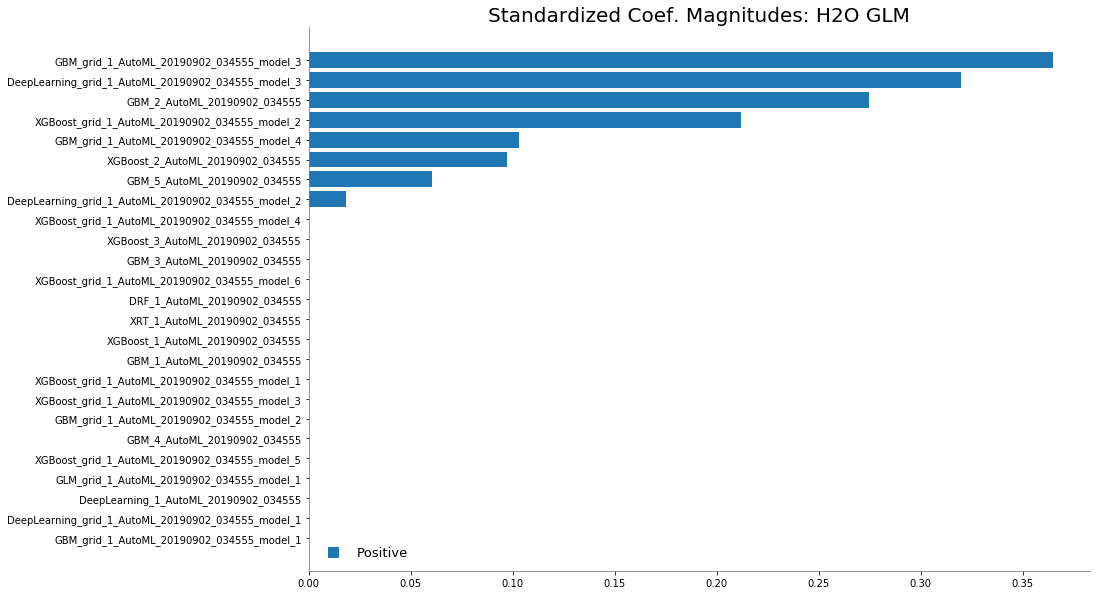

In [14]:
%matplotlib inline
metalearner.std_coef_plot()

## Save Leader Model
There are two ways to save the leader model -- binary format and MOJO format. If you're taking your leader model to production, then we'd suggest the MOJO format since it's optimized for production use.

In [15]:
# Save binary format
h2o.save_model(aml.leader, path = "./product_backorders_model_bin")

'/content/product_backorders_model_bin/StackedEnsemble_BestOfFamily_AutoML_20190902_034555'

In [16]:
# Save MOJO format
aml.leader.download_mojo(path = "./")

'/content/StackedEnsemble_BestOfFamily_AutoML_20190902_034555.zip'

# Predict

In [17]:
preds = aml.leader.predict(test[x])

stackedensemble prediction progress: |████████████████████████████████████| 100%


In [18]:
# Performance model
aml.leader.model_performance() 


ModelMetricsBinomialGLM: stackedensemble
** Reported on train data. **

MSE: 0.043910554420838195
RMSE: 0.209548453635044
LogLoss: 0.19867378839068411
Null degrees of freedom: 722
Residual degrees of freedom: 718
Null deviance: 880.06623240694
Residual deviance: 287.2822980129293
AIC: 297.2822980129293
AUC: 0.9958890313129463
pr_auc: 0.9853657829065264
Gini: 0.9917780626258925

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.47897425717561254: 

,,1,2,Error,Rate
0,1,501.0,7.0,0.0138,(7.0/508.0)
1,2,12.0,203.0,0.0558,(12.0/215.0)
2,Total,513.0,210.0,0.0263,(19.0/723.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.478974,0.955294,158.0
1,max f2,0.318461,0.970962,187.0
2,max f0point5,0.509346,0.964661,156.0
3,max accuracy,0.509346,0.973721,156.0
4,max precision,0.938461,1.000000,0.0
5,max recall,0.240140,1.000000,208.0
6,max specificity,0.938461,1.000000,0.0
7,max absolute_mcc,0.478974,0.936819,158.0
8,max min_per_class_accuracy,0.418176,0.967442,169.0
9,max mean_per_class_accuracy,0.333226,0.970743,184.0



Gains/Lift Table: Avg response rate: 29.74 %, avg score: 31.82 %


,,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain
0,,1,0.011065,0.926314,3.362791,3.362791,1.000000,0.931294,1.000000,0.931294,0.037209,0.037209,236.279070,236.279070
1,,2,0.020747,0.907528,3.362791,3.362791,1.000000,0.913683,1.000000,0.923076,0.032558,0.069767,236.279070,236.279070
2,,3,0.030429,0.895744,3.362791,3.362791,1.000000,0.900648,1.000000,0.915940,0.032558,0.102326,236.279070,236.279070
3,,4,0.040111,0.888530,3.362791,3.362791,1.000000,0.892289,1.000000,0.910231,0.032558,0.134884,236.279070,236.279070
4,,5,0.051176,0.875141,3.362791,3.362791,1.000000,0.885319,1.000000,0.904845,0.037209,0.172093,236.279070,236.279070
5,,6,0.100968,0.832397,3.362791,3.362791,1.000000,0.857489,1.000000,0.881491,0.167442,0.339535,236.279070,236.279070
6,,7,0.150761,0.785613,3.362791,3.362791,1.000000,0.807608,1.000000,0.857089,0.167442,0.506977,236.279070,236.279070
7,,8,0.200553,0.733191,3.269380,3.339599,0.972222,0.763526,0.993103,0.833860,0.162791,0.669767,226.937984,233.959904
8,,9,0.300138,0.454970,2.802326,3.161333,0.833333,0.609945,0.940092,0.759566,0.279070,0.948837,180.232558,216.133319
9,,10,0.399723,0.214422,0.513760,2.501730,0.152778,0.299452,0.743945,0.644935,0.051163,1.000000,-48.624031,150.173010


In [0]:
# Convert H2O Frame to Pandas DataFrame
y_test = test[y].as_data_frame()
y_pred = preds[0].as_data_frame()

In [20]:
from sklearn.metrics import f1_score

f1 = f1_score(y_test, y_pred)

print("Evaluation Performance")
print("F1-Score ={:.4f}".format(f1))

Evaluation Performance
F1-Score =0.7706
